# 2D object detraction

Pre-trained OWL-ViT 기반의 object detection 의 example code 입니다. 

본 코드는 [Example code](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb#scrollTo=fZJrboQlswuA) 를 기반으로 작성 되었습니다. 

In [1]:
# 기본 hugging-Face package install
#
# !pip install transformers
# !pip install datasets
# !pip install scikit-image

## Model and data-processor 
OWL-ViT Model 과 pre-train 된 data-processer 를 가져옵니다.

pre-train 된 data-processor 는 image 전처리 및 text data 에 대한 tokenizer 를 포함하고 있습니다.

In [2]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

In [14]:
# 확인해 보면 다음과 같습니다.
print(processor)

OwlViTProcessor:
- image_processor: OwlViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_center_crop",
    "crop_size",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "crop_size": {
    "height": 768,
    "width": 768
  },
  "do_center_crop": false,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "OwlViTImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "OwlViTProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 768,
    "width": 768
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='google/owlvit-base-patch32', vocab_size=49408, model_max_length=16, is_fast=True, pad

## Image Sample and text queries setting for inference test

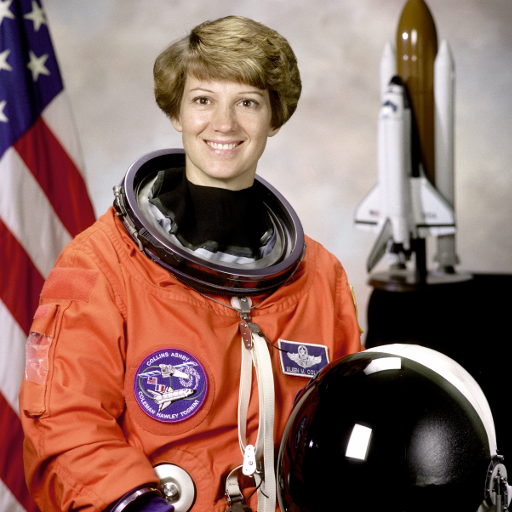

In [15]:
import cv2
import skimage
import numpy as np
from PIL import Image

# Download sample image
image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

# Text queries to search the image for
text_queries = ["human face", "rocket", "nasa badge", "star-spangled banner"]

image

## Set the device for inference

In [16]:
import torch
print(device := torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

cuda


Processor 의 입력으로 text-query 와 image 를 사용합니다. 

여기서, `retrun_tensors="pt"` 는 pytorch format 에 적합한 tensor 를 출력하도록 설정합니다.

> - 'pt': Return Pytorch tensors
> - 'tf': Retrun TensorFlow tensors
> - None: Returns python list(default)

In [17]:
# Process image and text inputs
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([4, 16])
attention_mask: torch.Size([4, 16])
pixel_values: torch.Size([1, 3, 768, 768])


> - `input_ids`: input text 에 대한 representation 이며, pre-train 된 model 의 vocabulary 안의 token 과 연관되어 있습니다. 
> - `attention_mask`: 1 과 0 으로 구성되어 있으며, 0 으로 표시된 부분이 masking 하는 부분입니다. 
> - `pixel_values`: 이미지 정보 입니다.

In [6]:
# Set model in evaluation mode
model = model.to(device)
model.eval()

# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}") 

logits: shape of torch.Size([1, 576, 4])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 4, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([4, 16, 512])
pooler_output: shape of torch.Size([4, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


In [7]:
import matplotlib.pyplot as plt

from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()

# Load example image
image_size = model.config.vision_config.image_size
image = mixin.resize(image, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

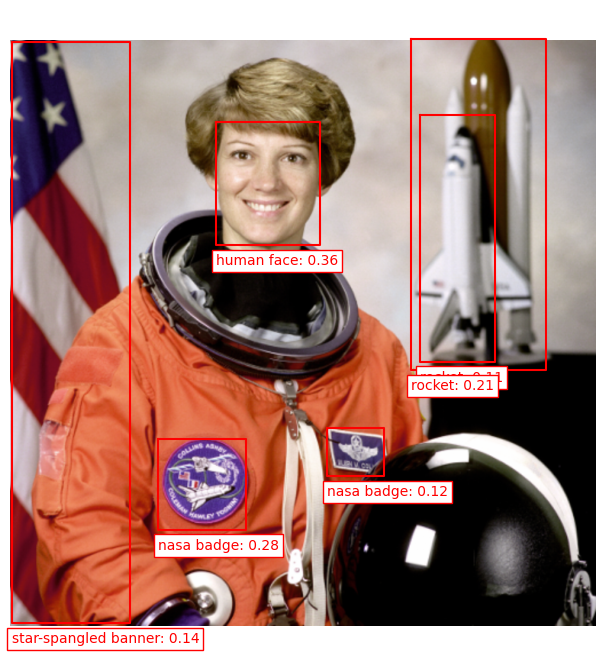

In [8]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue

      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })
    
plot_predictions(input_image, text_queries, scores, boxes, labels)

## Model inference test 를 위한 dataset 을 load 합니다

여기서는 food101 데이터 세트를 사용하도록 하겠습니다

> food101 dataset 자체가 상당히 크기 때문에 split parameter 로 일부만 가져오는 모습

In [1]:
from datasets import load_dataset

dataset = load_dataset('food101', split='train[:100]')

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

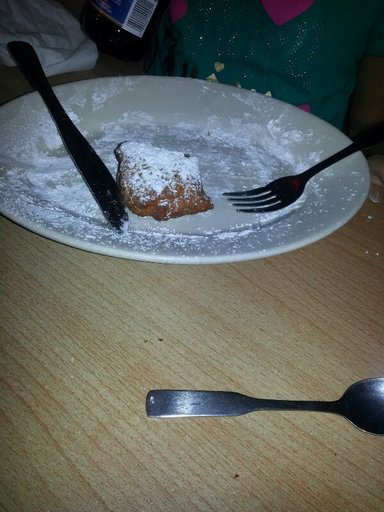

In [2]:
# test
dataset[0]['image']

In [ ]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')